In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtree

import numpy as np
import optax
import pandas as pd 
import matplotlib.pyplot as plt

from dln import (
    create_dln_model, 
    create_minibatches, 
    true_dln_learning_coefficient, 
    mse_loss, 
)
from mcmc_utils import (
    MCMCConfig,
    run_mcmc,
    rlct_estimate_regression,
)
import numpyro
import numpyro.distributions as dist

from utils import to_json_friendly_tree, running_mean

def generate_correlation_matrix(key, n):
    """
    Generate a random positive definite symmetric square matrix.
    
    :param key: JAX random key
    :param n: The size of the matrix (n x n)
    :return: A random positive definite symmetric square matrix
    """
    key, subkey = jax.random.split(key)
    A = jax.random.uniform(subkey, (n, n))
    B = jnp.dot(A, A.T)
    C = B / jnp.max(jnp.abs(B))  # Normalize to ensure diagonal elements are 1
    return (C + C.T) / 2  # Ensure perfect symmetry

@jax.jit
def tree_l2_dist(tree1, tree2):
    return jnp.sqrt(jnp.sum(jnp.stack(jtree.tree_flatten(jtree.tree_map(lambda x, y: jnp.sum((x - y) ** 2), tree1, tree2))[0])))


def build_mcmc_model(
        forward_fn, 
        sample_param_tree, 
        prior_config=None, 
        sigma_obs=1.0
    ):
    prior_loc = prior_config["loc"]
    prior_scale = prior_config["scale"]

    def mcmc_model(X, itemp=1.0):
        flatten_param, tree_def = jtree.tree_flatten(sample_param_tree)
        param = [
            numpyro.sample(
                i, 
                dist.Normal(prior_loc, prior_scale), 
                sample_shape=x.shape
            )
            for i, x in enumerate(flatten_param)
        ]
        param = jtree.tree_unflatten(tree_def, param)
        x, y = X
        mu = forward_fn(param, x)
        numpyro.sample("y", dist.Normal(mu, sigma_obs / jnp.sqrt(itemp)), obs=y)
        return 
    
    return mcmc_model

def collapse_first_two_dims(param):
    shape = param.shape
    new_shape = (shape[0] * shape[1],) + shape[2:]
    return param.reshape(new_shape)

def _extract_chain(samples, chain_id):
    return jtree.tree_map(lambda x: x[chain_id], samples)




INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
INFO:__main__:Running MCMC
sample: 100%|██████████| 21003/21003 [00:26<00:00, 795.85it/s, 1023 steps of size 4.77e-04. acc. prob=0.94]


In [16]:
expt_name = None

dln_config = dict(
    input_dim = 4,
    output_dim = 4,
    hidden_layer_widths = [4],
    initialisation_exponent = 1.5, 
    teacher_matrix = None,
)
mcmc_config = {
    'num_posterior_samples': 20003,
    'thinning': 10,
    'num_warmup': 1000,
    'num_chains': 1,
}

data_config = {
    "num_training_data": 5,
    "num_test_data": 5000,
    "feature_map": None, # None, ("polynomial", d)
    "output_noise_std": 0.1, 
    "input_noise_std": 1.0,
    "teacher_matrix": "random", # diagonal, "sparse", 
    "sparsity": None, 
    "idcorr": False,
}
loss_trace_minibatch = True # if True loss_trace uses minibatch, else use full dataset. 


itemp = 1 / np.log(data_config["num_training_data"])
num_itemps = 1
training_config = {
    "optim": "sgd", 
    "learning_rate": 1e-4, 
    "momentum": None, 
    "batch_size": 128, 
    "num_steps": 20000
}
seed = 0
logging_period = 50
verbose = False
do_plot = False





# seeding
np.random.seed(seed)
rngkey = jax.random.PRNGKey(seed)

####################
# Initialisations
####################
# create DLN model
input_dim = dln_config["input_dim"]
output_dim = dln_config["output_dim"]
hidden_layer_widths = dln_config["hidden_layer_widths"]
layer_widths = hidden_layer_widths + [output_dim]
initialisation_exponent = dln_config["initialisation_exponent"]
if dln_config["teacher_matrix"] is None:
    teacher_matrix = np.diag(np.linspace(50, 10, input_dim))
elif type(dln_config["teacher_matrix"]) == list:
    if len(dln_config["teacher_matrix"]) == 3:
        exponent, scale, start = dln_config["teacher_matrix"]
        # produce a matrix with the ith eigenvalue is given by scale / (start + i) ** exponent
        teacher_matrix = np.diag(scale / (start + np.arange(input_dim)) ** exponent)
    elif len(dln_config["teacher_matrix"]) == input_dim:
        teacher_matrix = np.diag(dln_config["teacher_matrix"])
    else:
        raise ValueError("Invalid teacher matrix specification")
else:
    raise ValueError("Invalid teacher matrix specification")
teacher_matrix = teacher_matrix[:output_dim, :input_dim]

# DLN model
initialisation_sigma = np.sqrt(input_dim ** (-initialisation_exponent))
model = create_dln_model(layer_widths, sigma=initialisation_sigma)
loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))

rngkey, subkey = jax.random.split(rngkey)
param_init = model.init(rngkey, jnp.zeros((1, input_dim)))



# create training data
num_training_data = data_config["num_training_data"]
num_test_data = data_config["num_test_data"]
use_idcorr = data_config["idcorr"]
output_noise_std = data_config["output_noise_std"]
initialisation_exponent = dln_config["initialisation_exponent"]


rngkey, rngkey = jax.random.split(rngkey)
if use_idcorr:
    feature_corr = np.eye(input_dim)
else:
    feature_corr = generate_correlation_matrix(rngkey, input_dim)
x_train = jax.random.multivariate_normal(
    rngkey, 
    jnp.zeros(input_dim), 
    feature_corr, 
    shape=(num_training_data,), 
    dtype=jnp.float32
)

rngkey, subkey = jax.random.split(rngkey)
y_train = (
    x_train @ teacher_matrix 
    + jax.random.normal(
        rngkey, 
        shape=(num_training_data, output_dim)) * output_noise_std
)

####################################################
# Run MCMC
####################################################
mcmc_config = MCMCConfig(
    num_posterior_samples=mcmc_config["num_posterior_samples"],
    thinning=mcmc_config["thinning"],
    num_warmup=mcmc_config["num_warmup"],
    num_chains=mcmc_config["num_chains"],
)
mcmc_model = build_mcmc_model(
    model.apply,
    param_init,
    prior_config={"loc": 0.0, "scale": 1.0},
    sigma_obs=output_noise_std,
)
rngkey, subkey = jax.random.split(rngkey)
mcmc = run_mcmc(
    mcmc_model,
    (x_train, y_train),
    rngkey,
    mcmc_config,
    init_params=None,
    itemp=itemp,
    progress_bar=True,
)
posterior_samples = mcmc.get_samples(group_by_chain=True)
tree_def = jtree.tree_structure(param_init)
posterior_samples = jtree.tree_unflatten(tree_def, [posterior_samples[key] for key in posterior_samples.keys()])
num_thin_posterior_samples_per_chain = jtree.tree_flatten(posterior_samples)[0][0].shape[1]

INFO:__main__:Running MCMC
sample: 100%|██████████| 21003/21003 [00:27<00:00, 763.05it/s, 1023 steps of size 1.19e-03. acc. prob=0.93]


In [17]:
print(jtree.tree_map(lambda x: x.shape, param_init))
print(jtree.tree_map(lambda x: x.shape, posterior_samples))
total_num_param = np.sum([np.prod(p.shape) for p in jtree.tree_flatten(param_init)[0]])
print(f"Total number of parameters: {total_num_param}")

{'deep_linear_network/linear': {'w': (4, 4)}, 'deep_linear_network/linear_1': {'w': (4, 4)}}
{'deep_linear_network/linear': {'w': (1, 2000, 4, 4)}, 'deep_linear_network/linear_1': {'w': (1, 2000, 4, 4)}}
Total number of parameters: 32


Text(0.5, 0, 'Loss')

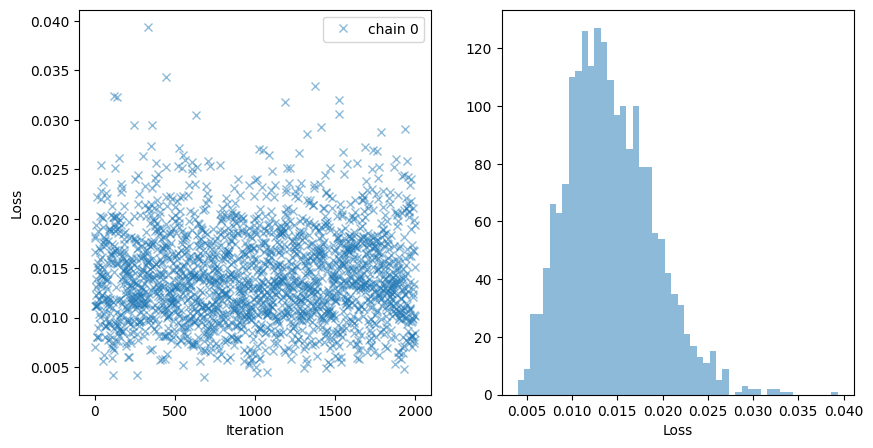

In [18]:
vmap_loss_fn = jax.vmap(loss_fn, in_axes=(jtree.tree_map(lambda x: 0, tree_def), None, None))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax1 = axes[1]
for i in range(mcmc_config.num_chains):
    loss_trace = vmap_loss_fn(_extract_chain(posterior_samples, i), x_train, y_train).flatten()
    ax.plot(loss_trace, "x", alpha=0.5, label=f"chain {i}")
    ax1.hist(loss_trace, bins=50, alpha=0.5, label=f"chain {i}")

ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")


ax1.set_xlabel("Loss")

Text(0, 0.5, 'L2 distance')

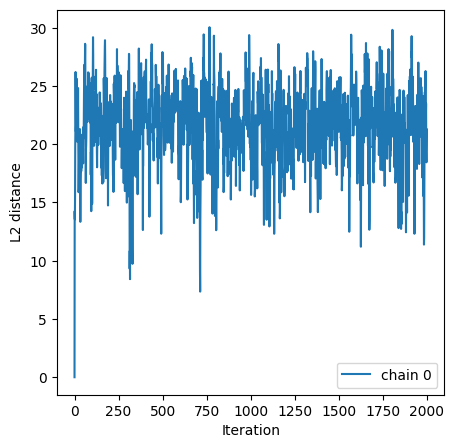

In [19]:

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for c in range(mcmc_config.num_chains):
    tree1 = jtree.tree_map(lambda x: x[c, 0], posterior_samples)
    distances = []
    for i in range(num_thin_posterior_samples_per_chain):
        tree2 = jtree.tree_map(lambda x: x[c, i], posterior_samples)
        distances.append(tree_l2_dist(tree1, tree2))
    ax.plot(distances, label=f"chain {c}")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("L2 distance")